/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Episode 1/1000, Total Reward: 27.0
Episode 2/1000, Total Reward: 40.0
Episode 3/1000, Total Reward: 17.0
Episode 4/1000, Total Reward: 44.0
Episode 5/1000, Total Reward: 15.0
Episode 6/1000, Total Reward: 12.0
Episode 7/1000, Total Reward: 30.0
Episode 8/1000, Total Reward: 18.0
Episode 9/1000, Total Reward: 21.0
Episode 10/1000, Total Reward: 29.0
Episode 11/1000, Total Reward: 30.0
Episode 12/1000, Total Reward: 26.0
Episode 13/1000, Total Reward: 28.0
Episode 14/1000, Total Reward: 14.0
Episode 15/1000, Total Reward: 13.0
Episode 16/1000, Total Reward: 14.0
Episode 17/1000, Total Reward: 78.0
Episode 18/1000, Total Reward: 18.0
Episode 19/1000, Total Reward: 30.0
Episode 20/1000, Total Reward: 22.0
Episode 21/1000, Total Reward: 16.0
Episode 22/1000, Total Reward: 51.0
Episode 23/1000, Total Reward: 13.0
Episode 24/1000, Total Reward: 27.0
Episode 25/1000, Total Reward: 22.0
Episode 26/1000, Total Reward: 14.0
Episode 27/1000, Total Reward: 12.0
Episode 28/1000, Total Reward: 27.0
E

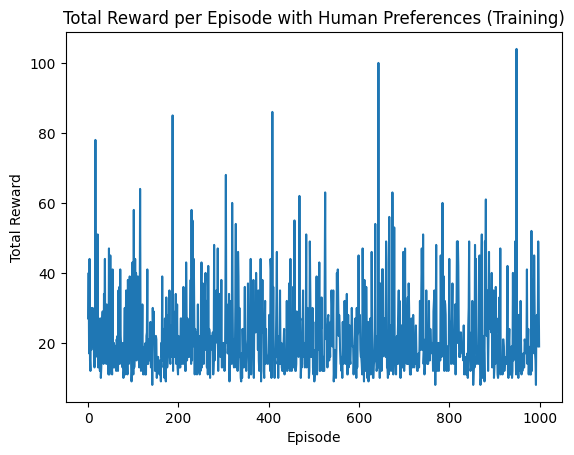

Evaluation Episode 1/100, Total Reward: 13.0
Evaluation Episode 2/100, Total Reward: 35.0
Evaluation Episode 3/100, Total Reward: 11.0
Evaluation Episode 4/100, Total Reward: 21.0
Evaluation Episode 5/100, Total Reward: 21.0
Evaluation Episode 6/100, Total Reward: 10.0
Evaluation Episode 7/100, Total Reward: 39.0
Evaluation Episode 8/100, Total Reward: 20.0
Evaluation Episode 9/100, Total Reward: 40.0
Evaluation Episode 10/100, Total Reward: 40.0
Evaluation Episode 11/100, Total Reward: 22.0
Evaluation Episode 12/100, Total Reward: 19.0
Evaluation Episode 13/100, Total Reward: 29.0
Evaluation Episode 14/100, Total Reward: 16.0
Evaluation Episode 15/100, Total Reward: 18.0
Evaluation Episode 16/100, Total Reward: 9.0
Evaluation Episode 17/100, Total Reward: 35.0
Evaluation Episode 18/100, Total Reward: 15.0
Evaluation Episode 19/100, Total Reward: 16.0
Evaluation Episode 20/100, Total Reward: 17.0
Evaluation Episode 21/100, Total Reward: 23.0
Evaluation Episode 22/100, Total Reward: 9.0

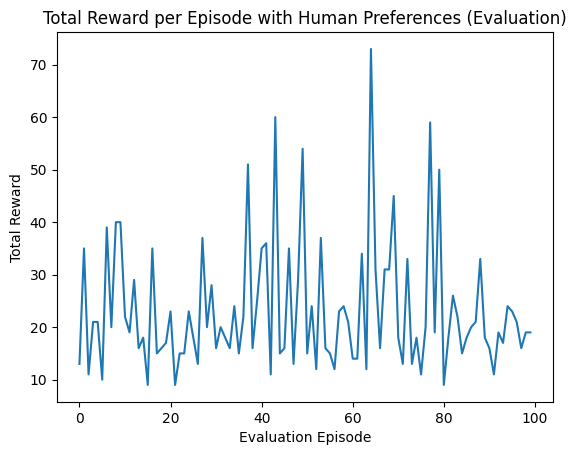

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque

class PreferenceModel(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(PreferenceModel, self).__init__()
        self.fc1 = nn.Linear(state_dim + action_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state, action):
        x = torch.cat((state, action), dim=-1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, action_dim)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return torch.softmax(self.fc3(x), dim=-1)

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, state):
        x = torch.relu(self.fc1(state))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

class LfHPAgent:
    def __init__(self, env, alpha=0.001, gamma=0.99, epsilon=1.0, epsilon_decay=0.995, min_epsilon=0.01, memory_size=10000, batch_size=64):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_dim = env.action_space.n
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.min_epsilon = min_epsilon
        self.batch_size = batch_size
        self.memory = deque(maxlen=memory_size)
        self.actor = Actor(self.state_dim, self.action_dim)
        self.critic = Critic(self.state_dim)
        self.preference_model = PreferenceModel(self.state_dim, 1)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=alpha)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=alpha)
        self.preference_optimizer = optim.Adam(self.preference_model.parameters(), lr=alpha)

    def remember(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):
        if np.random.rand() < self.epsilon:
            return self.env.action_space.sample()
        state = torch.FloatTensor(state).unsqueeze(0)
        with torch.no_grad():
            action_probs = self.actor(state)
        action_probs = action_probs + 1e-10  # Add a small epsilon to ensure no zeros
        action_probs = action_probs / torch.sum(action_probs)  # Normalize to ensure valid probability distribution
        if torch.isnan(action_probs).any() or torch.isinf(action_probs).any():
            action_probs = torch.ones_like(action_probs) / len(action_probs[0])  # Reset to uniform distribution if invalid
        return torch.multinomial(action_probs, 1).item()

    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)

        state_batch = torch.FloatTensor(state_batch)
        action_batch = torch.LongTensor(action_batch).unsqueeze(1)
        reward_batch = torch.FloatTensor(reward_batch).unsqueeze(1)
        next_state_batch = torch.FloatTensor(next_state_batch)
        done_batch = torch.FloatTensor(done_batch).unsqueeze(1)

        values = self.critic(state_batch)
        next_values = self.critic(next_state_batch).detach()
        target_values = reward_batch + self.gamma * next_values * (1 - done_batch)

        critic_loss = nn.MSELoss()(values, target_values)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        action_probs = self.actor(state_batch).gather(1, action_batch)
        advantages = target_values - values.detach()
        actor_loss = -(torch.log(action_probs) * advantages).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay

    def get_human_preference(self, state1, action1, state2, action2):
        # Simulate human preference
        reward1 = -1 if abs(state1[0, 2]) > 0.1 else 1
        reward2 = -1 if abs(state2[0, 2]) > 0.1 else 1
        return reward1 > reward2

    def update_preference_model(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state1, action1, reward1, next_state1, done1 in batch:
            state2, action2, reward2, next_state2, done2 = random.choice(self.memory)
            action1 = torch.FloatTensor([action1]).unsqueeze(0)
            action2 = torch.FloatTensor([action2]).unsqueeze(0)
            state1 = torch.FloatTensor(state1).unsqueeze(0)
            state2 = torch.FloatTensor(state2).unsqueeze(0)
            preference = self.get_human_preference(state1, action1, state2, action2)

            pred1 = self.preference_model(state1, action1)
            pred2 = self.preference_model(state2, action2)
            preference_target = torch.FloatTensor([[1.0], [0.0]]) if preference else torch.FloatTensor([[0.0], [1.0]])

            loss = nn.BCEWithLogitsLoss()(torch.cat((pred1, pred2)), preference_target)
            self.preference_optimizer.zero_grad()
            loss.backward()
            self.preference_optimizer.step()

def train(env, agent, episodes):
    rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.remember(state, action, reward, next_state, done)
            agent.replay()
            agent.update_preference_model()
            state = next_state
            total_reward += reward

        rewards.append(total_reward)
        print(f"Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
    return rewards

def evaluate(env, agent, episodes=100):
    total_rewards = []
    for episode in range(episodes):
        state = env.reset()
        total_reward = 0
        done = False
        while not done:
            action = agent.act(state)
            state, reward, done, _ = env.step(action)
            total_reward += reward
        total_rewards.append(total_reward)
        print(f"Evaluation Episode {episode+1}/{episodes}, Total Reward: {total_reward}")
    return total_rewards

# Main function to run the training
def main():
    env = gym.make('CartPole-v1')
    agent = LfHPAgent(env)
    episodes = 1000
    rewards = train(env, agent, episodes)

    # Plot the training rewards
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode with Human Preferences (Training)')
    plt.show()

    # Evaluate the trained agent
    evaluation_rewards = evaluate(env, agent)

    # Plot the evaluation rewards
    plt.plot(evaluation_rewards)
    plt.xlabel('Evaluation Episode')
    plt.ylabel('Total Reward')
    plt.title('Total Reward per Episode with Human Preferences (Evaluation)')
    plt.show()

if __name__ == "__main__":
    main()
